[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eyaler/workshop/blob/master/nn_7_ae.ipynb)

# 7. Autoencoders for image generation and novelty detection

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras import Input, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, UpSampling2D, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist, cifar10
from keras.utils import to_categorical

matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

Using TensorFlow backend.


In [0]:
# set random seeds for more reproducible results
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(43)

In [3]:
# load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
print(x_train.shape, y_train.shape)
gray = False
train_size = len(y_train)
test_size = len(y_test)
xdim = x_train.shape[1]
ydim = x_train.shape[2]
print(x_train.dtype, y_train.dtype)

11493376/11490434 [==============================] - 2s 0us/step
(60000, 28, 28, 1) (60000,)
uint8 uint8


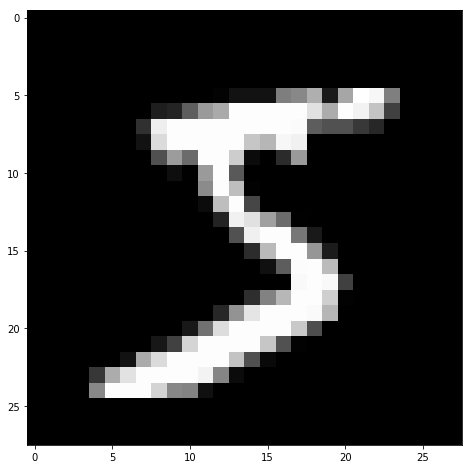

In [4]:
plt.imshow(x_train[0,...,0], cmap='gray')

In [5]:
print(np.min(x_train), np.max(x_train), np.median(x_train))
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

0 255 0.0
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))


In [0]:
x_train = np.asarray([x for x,y in zip(x_train,y_train) if y in (2,3,5,6,8)])


In [0]:
n_classes = len(np.unique(y_train))
x_train = shuffle(x_train, random_state=44)
x_train = x_train/255
x_test = x_test/255


In [0]:
def get_model():
    inputs = Input(shape=(xdim, ydim,1))
    f = Conv2D(filters=8, kernel_size=3, activation='relu', padding='same')(inputs)
    f = MaxPooling2D()(f)
    f = Conv2D(filters=8, kernel_size=3, activation='relu', padding='same')(f)
    f = MaxPooling2D()(f)
    f = Conv2D(filters=2, kernel_size=3, activation='relu', padding='same')(f)
    encoded = MaxPooling2D(padding='same')(f)
    
    f = Conv2D(filters=2, kernel_size=3, activation='relu', padding='same')(encoded)
    f = UpSampling2D()(f)
    f = Conv2D(filters=8, kernel_size=3, activation='relu', padding='same')(f)
    f = UpSampling2D()(f)
    f = Conv2D(filters=8, kernel_size=3, activation='relu')(f)
    f = UpSampling2D()(f)
    outputs = Conv2D(filters=1, kernel_size=3, activation='sigmoid', padding='same')(f)
    
    return Model(inputs=inputs, outputs=outputs), Model(inputs=inputs, outputs=encoded)

In [9]:
model, encoder = get_model()

print(model.summary())
model.compile(optimizer='adadelta', loss='binary_crossentropy')
history = model.fit(x=x_train, y=x_train, batch_size=512, epochs=300, validation_split=0.2)






Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 2)           146       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 2)          

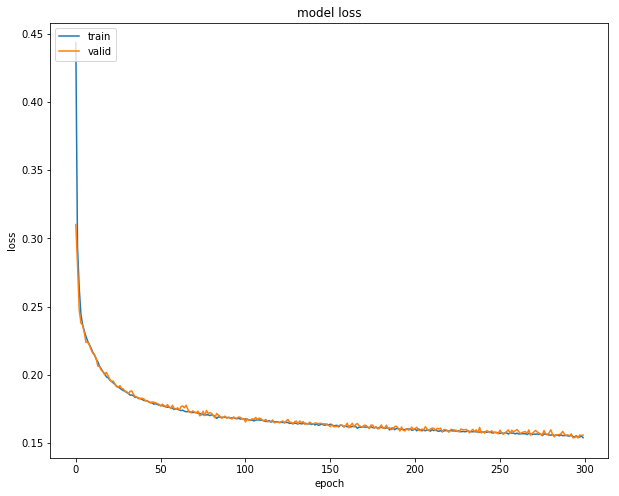

In [10]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [0]:
x_normal = np.asarray([x for x,y in zip(x_test,y_test) if y in (2,3,5,6,8)])
x_novel = np.asarray([x for x,y in zip(x_test,y_test) if y==4])
recon_normal = model.predict(x_normal)
recon_novel = model.predict(x_novel)

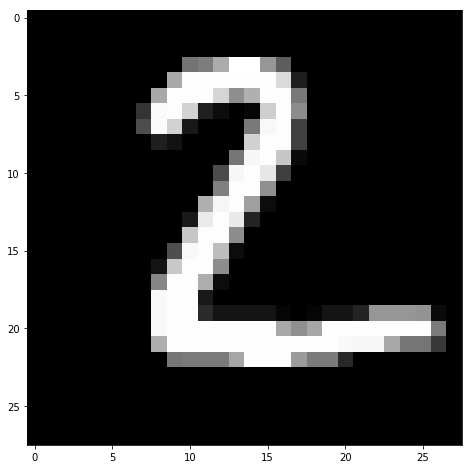

In [12]:
plt.imshow(x_normal[0,...,0], cmap='gray')


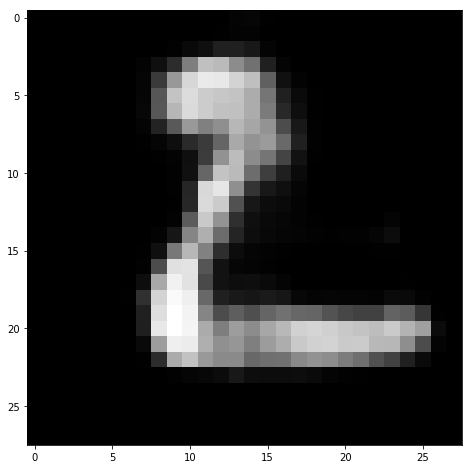

In [13]:
plt.imshow(recon_normal[0,...,0],cmap='gray')

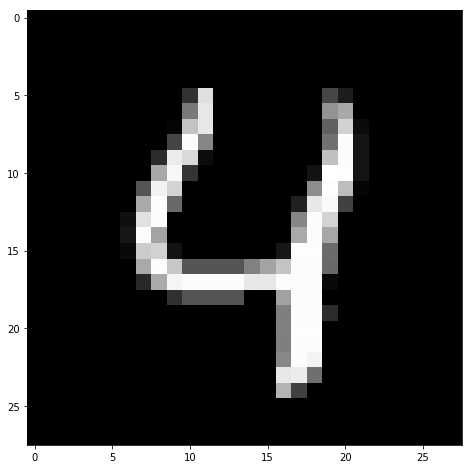

In [14]:
plt.imshow(x_novel[0,...,0], cmap='gray')

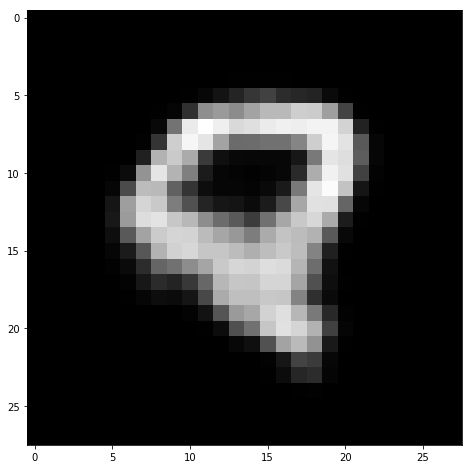

In [15]:
plt.imshow(recon_novel[0,...,0],cmap='gray')

0.15544834308443814 0.18513245557848385


(array([ 0.29805114,  1.68895646,  3.27856253,  5.66297164,  9.83568759,
        10.43178987, 12.31944708, 10.92854177, 11.32594329,  8.44478228,
         5.96102278,  5.06686937,  4.37141671,  2.68246025,  1.39090532,
         1.4902557 ,  0.79480304,  0.79480304,  0.39740152,  0.39740152]),
 array([0.10452831, 0.11477819, 0.12502808, 0.13527796, 0.14552785,
        0.15577773, 0.16602762, 0.1762775 , 0.18652739, 0.19677727,
        0.20702716, 0.21727704, 0.22752693, 0.23777681, 0.2480267 ,
        0.25827658, 0.26852646, 0.27877635, 0.28902623, 0.29927612,
        0.309526  ]),
 <a list of 20 Patch objects>)

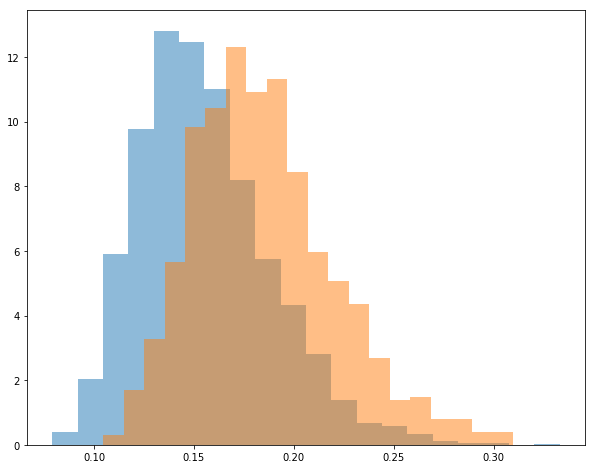

In [16]:
error_normal = -np.mean(np.log(recon_normal+1e-19)*x_normal+np.log(1-recon_normal+1e-19)*(1-x_normal),axis=(1,2,3))
error_novel = -np.mean(np.log(recon_novel+1e-19)*x_novel+np.log(1-recon_novel+1e-19)*(1-x_novel),axis=(1,2,3))
print(np.mean(error_normal),np.mean(error_novel))
plt.hist(error_normal, 20, density=True, alpha=0.5, label='normal')
plt.hist(error_novel, 20, density=True, alpha=0.5, label='novel')

In [0]:
code_normal = np.reshape(encoder.predict(x_normal),(-1,32))
code_novel = np.reshape(encoder.predict(x_novel),(-1,32))

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca')
low = tsne.fit_transform(np.vstack((code_normal,code_novel)))


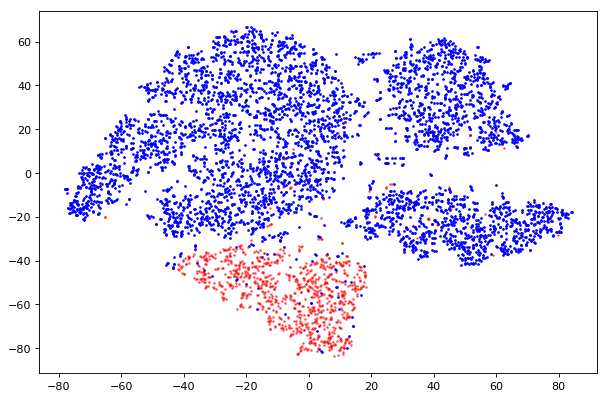

In [19]:
t_normal = low[:len(code_normal)]
t_novel = low[len(code_normal):]
fig=plt.figure(figsize=(9,6), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(t_normal[:,0],t_normal[:,1],color='b',s=2)
plt.scatter(t_novel[:,0],t_novel[:,1],color='r',alpha=0.5,s=2)
plt.show()
